## Example notebook

This notebook shows how to run ORIGIN on a sub-cube from the UDF10 (http://muse-vlt.eu/science/udf/).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Image, Cube
from mpdaf.sdetect import Catalog

import muse_origin
from muse_origin import ORIGIN

print(muse_origin.__version__)

3.2.dev168+g37122b7.d20190716


To run ORIGIN we need a data cube and its associate FSF.  There are two ways to specify the PSF informations:

- with the ``PSF``, ``FWHM_PSF``, and ``LBDA_FWHM`` parameters.
- or it can be read from the cube header, when the cube contains the keywords required by [mpdaf.MUSE.FSFModel](https://mpdaf.readthedocs.io/en/latest/api/mpdaf.MUSE.FSFModel.html#mpdaf.MUSE.FSFModel), see below.

In [2]:
DATACUBE = 'UDF10-small/DATACUBE_UDF-10-small.fits'
NAME = 'UDF10-example'

This cube has been cropped both spatially and spectrally to make the example simpler and faster to run:

In [3]:
Cube(DATACUBE).info()

[INFO] 800 x 100 x 200 Cube (UDF10-small/DATACUBE_UDF-10-small.fits)
[INFO] .data(800 x 100 x 200) (1e-20 erg / (Angstrom cm2 s)), .var(800 x 100 x 200)
[INFO] center:(-27:47:05.8675,03:32:39.6074) size:(20.000",40.000") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:5000.00 max:5998.75 step:1.25 Angstrom


And it contains the FSF information:

In [4]:
from mpdaf.MUSE import FSFModel

fsfmodel = FSFModel.read(DATACUBE)
fsfmodel.to_header()

FSFMODE = 'MOFFAT1 '           / Old model with a fixed beta                    
FSF00BET=                  2.8                                                  
FSF00FWA=                0.831                                                  
FSF00FWB=           -3.007E-05                                                  

### Create the ORIGIN object

In [5]:
orig = ORIGIN.init(DATACUBE, name=NAME, loglevel='DEBUG', logcolor=True)

INFO: Step 00 - Initialization (ORIGIN v3.2.dev168+g37122b7.d20190716)
INFO: Read the Data Cube UDF10-small/DATACUBE_UDF-10-small.fits
INFO: Compute FSFs from the datacube FITS header keywords
INFO: mean FWHM of the FSFs = 3.33 pixels
INFO: 00 Done


The logging level can be modified with the `set_loglevel` method:

In [6]:
orig.set_loglevel('INFO')

### Step01 - Preprocessing

Now let's run the first which subtract the continuum with a DCT, standardize the cube, and creates a segmentation map.

Note that there are progress bar but they are not rendered in the HTML version.

In [7]:
orig.step01_preprocessing()

INFO: Step 01 - Preprocessing
INFO: DCT computation



INFO: Data standardizing
INFO: Std signal saved in self.cube_std and self.ima_std
INFO: Compute local maximum of std cube values
INFO: Save self.cube_local_max/self.cube_local_min from max/min correlations
INFO: DCT continuum saved in self.cont_dct and self.ima_dct
INFO: Segmentation based on the continuum
INFO: Found 26 regions, threshold=1.28
INFO: Segmentation based on the residual
INFO: Found 16 regions, threshold=0.46
INFO: Merging both maps
INFO: Segmap saved in self.segmap_merged (35 regions)
INFO: 01 Done - 9.62 sec.


This produces several MPDAF [Image](https://mpdaf.readthedocs.io/en/latest/api/mpdaf.obj.Image.html#mpdaf.obj.Image) and [Cube](https://mpdaf.readthedocs.io/en/latest/api/mpdaf.obj.Cube.html#mpdaf.obj.Cube) objects: `ima_dct` is the continuum image estimated with the DCT, and `ima_std` is the image from the standardized cube.

In [8]:
orig.ima_white, orig.ima_dct, orig.ima_std

(<Image(shape=(100, 200), unit='1e-20 erg / (Angstrom cm2 s)', dtype='float64')>,
 <Image(shape=(100, 200), unit='', dtype='float64')>,
 <Image(shape=(100, 200), unit='', dtype='float64')>)

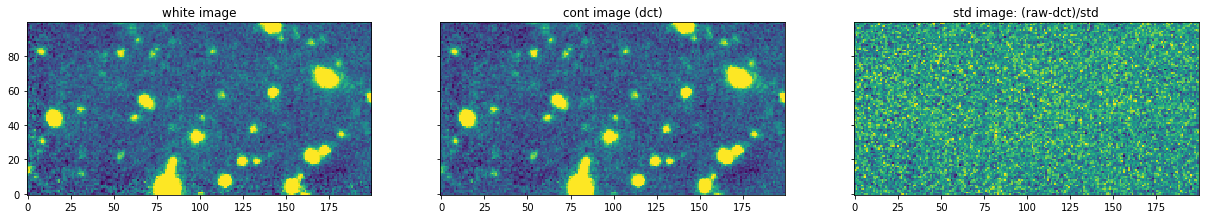

In [9]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(21, 4))
images = [orig.ima_white, orig.ima_dct, orig.ima_std]
titles = ['white image', 'cont image (dct)', 'std image: (raw-dct)/std']
for ax, im, title in zip(axes.flat, images, titles):
    im.plot(ax=ax, title=title, zscale=True)

This step also produced two segmentation maps which will be useful in the following steps:

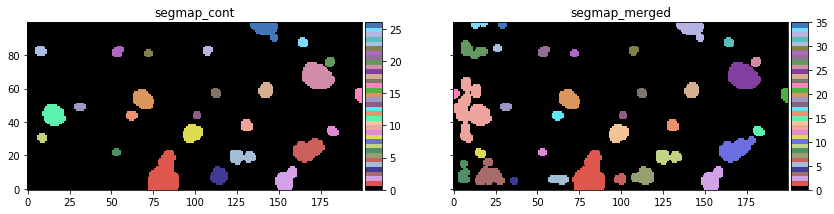

In [10]:
orig.plot_segmaps(figsize=(7, 4))

### Step02: Define areas for PCA

This step computes areas which will be used to dispatch the PCA computation on multiple processes. Here for the example we use a small size for areas, but for a normal cube the default setting (`minsize=100`) is more reasonable.

In [11]:
orig.step02_areas(minsize=50, maxsize=100)

INFO: Step 02 - Areas creation
INFO: First segmentation of 2^2 square
INFO: Save the map of areas in self.areamap
INFO: 4 areas generated
INFO: 02 Done - 0.20 sec.


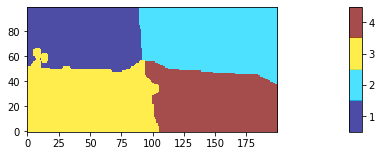

In [12]:
orig.plot_areas()

### Step03: PCA threshold

Now we compute the thresholds for the PCA, for each area.

In [13]:
orig.step03_compute_PCA_threshold(pfa_test=0.01)

INFO: Step 03 - PCA threshold computation
INFO: Area 1, estimation mean/std/threshold: 0.396939/0.032494/0.472532
INFO: Area 2, estimation mean/std/threshold: 0.380288/0.023576/0.435133
INFO: Area 3, estimation mean/std/threshold: 0.412613/0.035166/0.494422
INFO: Area 4, estimation mean/std/threshold: 0.397165/0.028599/0.463696
INFO: 03 Done - 0.13 sec.


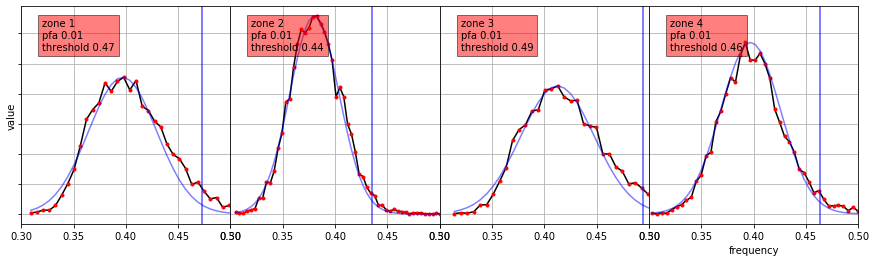

In [14]:
fig = plt.figure(figsize=(15, 4))
orig.plot_step03_PCA_threshold(fig=fig, xlim=(0.3, 0.5), ncol=4)

### Step04: Compute PCA

Loop on each area and compute the greedy PCA.

In [15]:
orig.step04_compute_greedy_PCA()

INFO: Step 04 - Greedy PCA computation
INFO:    - List of threshold = 0.47 0.44 0.49 0.46
INFO: Compute greedy PCA on each zone



INFO: Save the faint signal in self.cube_faint
INFO: Save numbers of iterations used by testO2 for each spaxel in self.mapO2
INFO: 04 Done - 2.63 sec.


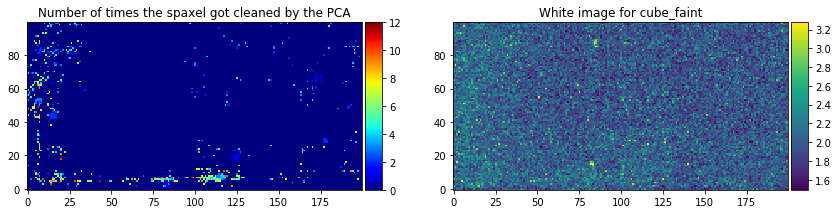

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
orig.plot_mapPCA(ax=ax1)
ima_faint = orig.cube_faint.max(axis=0)
ima_faint.plot(ax=ax2, colorbar='v',zscale=True, title='White image for cube_faint');

### Saving and reloading the session

ORIGIN keeps all intermediate results in memory, as attributes of the ORIGIN object. Saving the session will write these objects to disk and unload them which can be useful to free some memory. When reloading the session ORIGIN loads only the attribute that are needed.

In [17]:
orig.write()

INFO: Writing...
INFO: Current session saved in ./UDF10-example


In [18]:
orig = ORIGIN.load(NAME)

INFO: Step 00 - Initialization (ORIGIN v3.2.dev168+g37122b7.d20190716)
INFO: Read the Data Cube UDF10-small/DATACUBE_UDF-10-small.fits
INFO: Compute FSFs from the datacube FITS header keywords
INFO: mean FWHM of the FSFs = 3.33 pixels
INFO: 00 Done


In [19]:
orig.status()

- 01, preprocessing: DUMPED
- 02, areas: DUMPED
- 03, compute_PCA_threshold: DUMPED
- 04, compute_greedy_PCA: DUMPED
- 05, compute_TGLR: NOTRUN
- 06, compute_purity_threshold: NOTRUN
- 07, detection: NOTRUN
- 08, compute_spectra: NOTRUN
- 09, clean_results: NOTRUN
- 10, create_masks: NOTRUN
- 11, save_sources: NOTRUN


### Step05: Compute Correlations

Computes the spatial correlation with the FSF and the spectral correlation with the profiles from the dictionary, keeping only the maximum and minimum correlations.

In [20]:
pcut = 1e-08

orig.step05_compute_TGLR(ncpu=1, pcut=pcut)
orig.write()

INFO: Step 05 - GLR test
INFO: Correlation
INFO: Load dictionary of spectral profile /home/simon/dev/muse-origin/muse_origin/Dico_3FWHM.fits
INFO: Step 1/3 and 2/3: Spatial convolution of weighted data with the zero-mean FSF, Computing Spatial part of the norm of the 3D atoms



INFO: Step 3/3 Computing second cube of correlation values



INFO: Save the TGLR value in self.cube_correl
INFO: Save the number of profile associated to the TGLR in self.cube_profile
INFO: Save the map of maxima in self.maxmap
INFO: Compute p-values of local maximum of correlation values
INFO: Save self.cube_local_max from max correlations
INFO: Save self.cube_local_min from min correlations
INFO: 05 Done - 11.57 sec.
INFO: Writing...
INFO: Current session saved in /home/simon/dev/muse-origin-work/UDF10-example


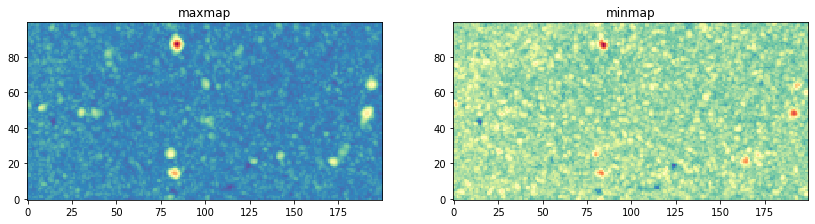

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
orig.maxmap.plot(ax=ax1, title='maxmap', cmap='Spectral_r')
(-1*orig.minmap).plot(ax=ax2, title='minmap', cmap='Spectral_r');

### Step06: Compute detection threshold

Find the thresholds for a given purity.

In [23]:
orig.step06_compute_purity_threshold(purity=0.8, purity_std=0.95)

INFO: Step 06 - Compute Purity threshold
INFO: Estimation of threshold with purity = 0.80
INFO: using only background pixels (83.4%)



INFO: Interpolated Threshold 4.61 Detection 30 for Purity 0.80
INFO: Threshold: 4.61 
INFO: Estimation of threshold std with purity = 0.95



INFO: Interpolated Threshold 3.50 Detection 8 for Purity 0.95
INFO: Threshold: 3.50 
INFO: 06 Done - 0.50 sec.


We can plot the purity to see how it was computed. Note that here the plot is noisy because of the small field size, which means that we don't have enough statistics.

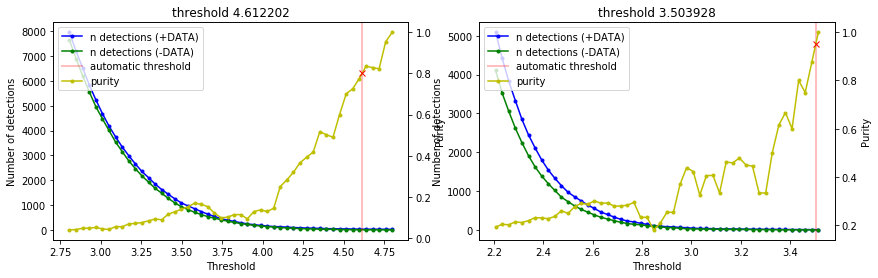

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
orig.plot_purity(ax=ax1)
orig.plot_purity(ax=ax2, comp=True)

We can also look at the histograms of local maxima and minima:

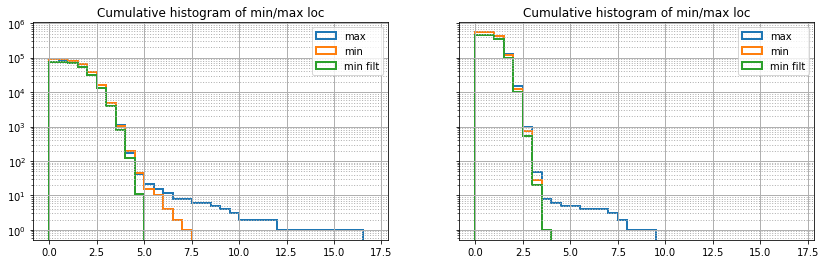

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True, sharex=True)
orig.plot_min_max_hist(ax=ax1)
orig.plot_min_max_hist(ax=ax2, comp=True) 

### Step07: Detection

Build the catalog of detections using the thresholds computed above (it is also possible to pass thresholds as arguments).

In [26]:
orig.threshold_correl, orig.threshold_std

(4.6122018469052914, 3.5039276373749044)

In [27]:
orig.step07_detection()

INFO: Step 07 - Thresholding and spatio-spectral merging
INFO: Thresholding correl (>4.61)
INFO: 32 detected lines
INFO: Thresholding std (>3.50)
INFO: 8 detected lines
INFO: kept 5 lines from std after filtering
INFO: Using segmap_cont with an additional deblending step
INFO: Spatio-spectral merging...
INFO: Purity estimation
INFO: Save the catalog in self.Cat1 (34 [+0] sources, 37 [+5] lines)
INFO: 07 Done - 0.78 sec.


We get two catalogs if the individual line detections and the matched detections, with their position and detection score.

- `Cat0` : The catalog with all detections (correl and comp).
- `Cat1` : The catalog with filtered and matched detections.

In [28]:
orig.Cat1

ID,ra,dec,lbda,x0,y0,z0,comp,STD,T_GLR,profile,seg_label,imatch,imatch2,purity
int64,float64,float64,float64,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,float64
1,53.1648108850977,-27.785768738291388,5025.0,103,35,20,0,nan,4.63,1,5,1,1,0.831
2,53.1712788889,-27.78476888885814,5030.0,0,53,24,0,nan,5.34,1,0,2,2,1.000
3,53.1683903263454,-27.783491081057665,5202.5,46,76,162,0,nan,5.16,1,0,3,3,1.000
4,53.16845312984622,-27.78315774901806,5261.25,45,82,209,0,nan,5.71,1,0,4,4,1.000
5,53.16455979661396,-27.78421317082869,5345.0,107,63,276,0,nan,4.84,1,0,5,5,1.000
6,53.16236178503014,-27.78637971378824,5367.5,142,24,294,0,nan,6.39,1,0,6,6,1.000
7,53.16054066993131,-27.78654625162608,5422.5,171,21,338,0,nan,8.09,2,29,7,7,1.000
8,53.16493650656938,-27.785268744085606,5425.0,101,44,340,0,nan,5.70,1,10,8,8,1.000
9,53.164999369812364,-27.784102080281805,5431.25,100,65,345,0,nan,6.43,1,0,9,9,1.000


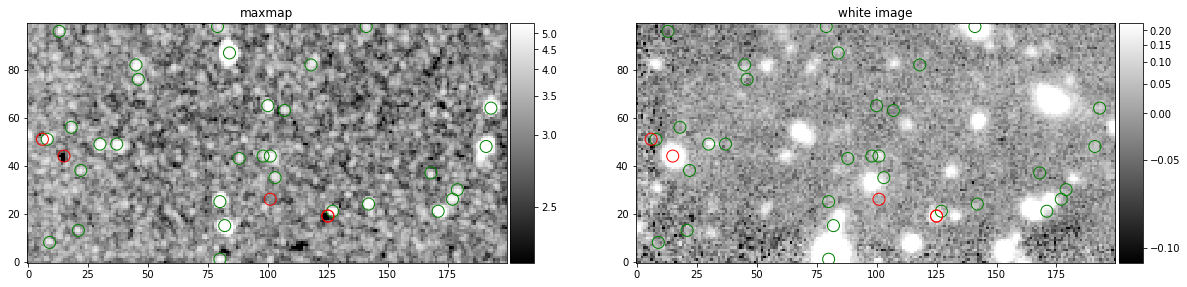

In [29]:
cat0 = Catalog(orig.Cat1[orig.Cat1['comp']==0])
cat1 = Catalog(orig.Cat1[orig.Cat1['comp']==1])

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

orig.maxmap.plot(ax=ax1, zscale=True, colorbar='v', cmap='gray', scale='asinh', title='maxmap')
orig.ima_white.plot(ax=ax2, zscale=True, colorbar='v', cmap='gray', scale='asinh', title='white image')

for ax in (ax1, ax2):
    cat0.plot_symb(ax, orig.maxmap.wcs, ecol='g', esize=1.0, ra='ra', dec='dec')
    if len(cat1) > 0:
        cat1.plot_symb(ax, orig.maxmap.wcs, ecol='r', esize=1.0, ra='ra', dec='dec')

#### Use of the segmentation map

During the lines matching step, a segmentation map is used to know if the detected lines belong to a bright sources or not. For lines in a bright source area the matching of lines is more extended to avoid having multiple sources detected in these areas. 

The consequence of this is that a good segmentation map is needed. By default a segmentation map is computed with [photutils](https://photutils.readthedocs.io/en/stable/), and it is also possible to provide one (see below).

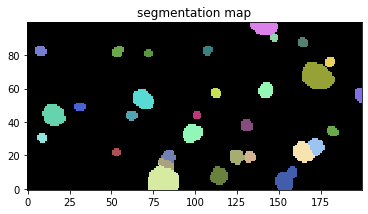

In [30]:
from photutils.utils.colormaps import random_cmap

cmap = random_cmap(ncolors=len(np.unique(orig.segmap_label._data)))
cmap.colors[0] = (0.0, 0.0, 0.0)

orig.segmap_label.plot(cmap=cmap, title='segmentation map');

#### Create a custom segmentation map

In [31]:
from muse_origin import compute_deblended_segmap

In [32]:
IMAGE = 'UDF10-small/IMAGE_UDF-10-small.fits'
im = Image(IMAGE)

In [33]:
segmap = compute_deblended_segmap(im, fwhm=3)

INFO: Background Median -0.01 RMS 0.03 Threshold 0.09


In [34]:
SEGMAP = 'UDF10-small/udf10-segmap-small.fits'
segmap.write(SEGMAP)

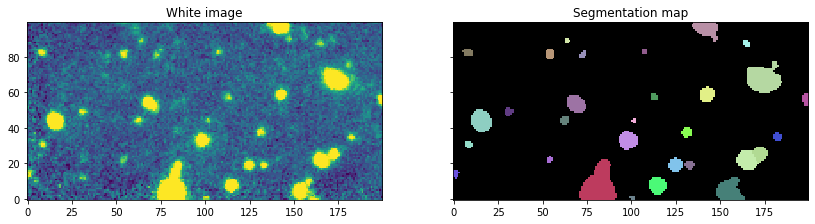

In [35]:
cmap = random_cmap(ncolors=len(np.unique(segmap._data)))
cmap.colors[0] = (0.0, 0.0, 0.0)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 4))
im.plot(ax=ax1, title='White image', zscale=True)
segmap.plot(ax=ax2, title='Segmentation map', cmap=cmap);

In [36]:
orig.step07_detection(segmap=SEGMAP)
orig.write()

INFO: Step 07 - Thresholding and spatio-spectral merging
INFO: Thresholding correl (>4.61)
INFO: 32 detected lines
INFO: Thresholding std (>3.50)
INFO: 8 detected lines
INFO: kept 5 lines from std after filtering
INFO: Overriding segmap_cont with the given one
INFO: Spatio-spectral merging...
INFO: Purity estimation
INFO: Save the catalog in self.Cat1 (34 [+0] sources, 37 [+5] lines)
INFO: 07 Done - 0.25 sec.
INFO: Writing...
INFO: Current session saved in /home/simon/dev/muse-origin-work/UDF10-example


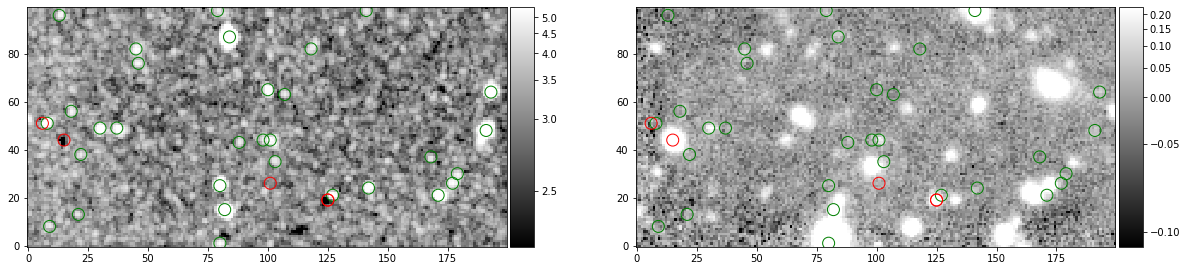

In [37]:
cat0 = Catalog(orig.Cat1[orig.Cat1['comp']==0])
cat1 = Catalog(orig.Cat1[orig.Cat1['comp']==1])

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

orig.maxmap.plot(ax=ax1, zscale=True, colorbar='v', cmap='gray', scale='asinh')
orig.ima_white.plot(ax=ax2, zscale=True, colorbar='v', cmap='gray', scale='asinh')

for ax in (ax1, ax2):
    cat0.plot_symb(ax, orig.maxmap.wcs, ecol='g', esize=1.0, ra='ra', dec='dec')
    if len(cat1) > 0:
        cat1.plot_symb(ax, orig.maxmap.wcs, ecol='r', esize=1.0, ra='ra', dec='dec')

In [38]:
orig.status()

- 01, preprocessing: DUMPED
- 02, areas: DUMPED
- 03, compute_PCA_threshold: DUMPED
- 04, compute_greedy_PCA: DUMPED
- 05, compute_TGLR: DUMPED
- 06, compute_purity_threshold: DUMPED
- 07, detection: DUMPED
- 08, compute_spectra: NOTRUN
- 09, clean_results: NOTRUN
- 10, create_masks: NOTRUN
- 11, save_sources: NOTRUN


### Step08: Compute Spectra

Compute the estimated emission line and the optimal coordinates.

In [39]:
orig.step08_compute_spectra()

INFO: Step 08 - Lines estimation



INFO: Save the updated catalog in self.Cat2 (37 lines)
INFO: Save estimated spectrum of each line in self.spectra
INFO: 08 Done - 2.64 sec.


### Step09: Clean results

This step cleans the results of ORIGIN and create the final catalogs (see below).

In [40]:
orig.step09_clean_results()

INFO: Step 09 - Results cleaning



INFO: Save the unique source catalog in self.Cat3_sources (34 sources)
INFO: Save the cleaned lines in self.Cat3_lines (37 lines)
INFO: 1 lines were merged in nearby lines
INFO: 09 Done - 0.98 sec.


### Step10: Create masks

In [41]:
orig.step10_create_masks()

INFO: Step 10 - Mask creation



INFO: 10 Done - 1.24 sec.


In [42]:
orig.write()

INFO: Writing...
INFO: Current session saved in /home/simon/dev/muse-origin-work/UDF10-example


### Step11: Create sources

In [43]:
orig = ORIGIN.load(NAME)

INFO: Step 00 - Initialization (ORIGIN v3.2.dev168+g37122b7.d20190716)
INFO: Read the Data Cube UDF10-small/DATACUBE_UDF-10-small.fits
INFO: Compute FSFs from the datacube FITS header keywords
INFO: mean FWHM of the FSFs = 3.33 pixels
INFO: 00 Done


In [44]:
orig.step11_save_sources('0.1')

INFO: Step 11 - Save sources
INFO: Writing...
INFO: Current session saved in /home/simon/dev/muse-origin-work/UDF10-example



INFO: Create the final catalog...


[INFO] Building catalog from path /home/simon/dev/muse-origin-work/UDF10-example/sources


 100%INFO: 11 Done - 31.68 sec.


In [45]:
orig.write()

INFO: Writing...
INFO: Current session saved in /home/simon/dev/muse-origin-work/UDF10-example


### Summary

In [46]:
orig.status()

- 01, preprocessing: DUMPED
- 02, areas: DUMPED
- 03, compute_PCA_threshold: DUMPED
- 04, compute_greedy_PCA: DUMPED
- 05, compute_TGLR: DUMPED
- 06, compute_purity_threshold: DUMPED
- 07, detection: DUMPED
- 08, compute_spectra: DUMPED
- 09, clean_results: DUMPED
- 10, create_masks: DUMPED
- 11, save_sources: DUMPED


Detection statistics:

In [47]:
orig.stat()

INFO: ORIGIN PCA pfa 0.01 Back Purity: 0.80 Threshold: 4.61 Bright Purity 0.95 Threshold 3.50
INFO: Nb of detected lines: 37
INFO: Nb of sources Total: 34 Background: 25 Cont: 9
INFO: Nb of sources detected in faint (after PCA): 30 in std (before PCA): 4


Computation time:

In [48]:
orig.timestat()

INFO: step01_preprocessing executed: 2019-07-17T12:54:15.800018 run time: 0:00:09.618713
INFO: step02_areas executed: 2019-07-17T12:54:17.203380 run time: 0:00:00.198090
INFO: step03_compute_PCA_threshold executed: 2019-07-17T12:54:17.573866 run time: 0:00:00.128114
INFO: step04_compute_greedy_PCA executed: 2019-07-17T12:54:20.868338 run time: 0:00:02.628998
INFO: step05_compute_TGLR executed: 2019-07-17T12:54:36.129974 run time: 0:00:11.569625
INFO: step06_compute_purity_threshold executed: 2019-07-17T12:56:04.902311 run time: 0:00:00.498243
INFO: step07_detection executed: 2019-07-17T12:56:10.443848 run time: 0:00:00.247567
INFO: step08_compute_spectra executed: 2019-07-17T12:56:14.313520 run time: 0:00:02.641411
INFO: step09_clean_results executed: 2019-07-17T12:56:15.306764 run time: 0:00:00.984085
INFO: step10_create_masks executed: 2019-07-17T12:56:16.558158 run time: 0:00:01.240162
INFO: step11_save_sources executed: 2019-07-17T12:56:48.875564 run time: 0:00:31.680841
INFO: *** 

### Final catalogs

Step 9 creates two catalogs, `Cat3_sources` which is the final catalog with the detected sources, and `Cat3_lines` with all the detected lines:

In [49]:
orig.Cat3_sources

ID,ra,dec,x,y,n_lines,seg_label,comp,line_merged_flag,flux,STD,nsigSTD,T_GLR,nsigTGLR,purity
int64,float64,float64,float64,float64,int64,int64,int64,bool,float64,float64,float64,float64,float64,float64
1,53.165,-27.786,103.0,35.0,1,9,0,False,54.5,nan,nan,4.63,5.64,0.831
2,53.171,-27.785,0.0,53.0,1,0,0,False,197.5,nan,nan,5.34,6.50,1.000
3,53.168,-27.783,46.0,76.0,1,0,0,False,76.9,nan,nan,5.16,6.28,1.000
4,53.168,-27.783,44.99999999999999,82.0,1,0,0,False,91.9,nan,nan,5.71,6.96,1.000
5,53.165,-27.784,107.0,63.00000000000001,1,0,0,False,67.5,nan,nan,4.84,5.89,1.000
6,53.162,-27.786,142.0,24.0,1,0,0,False,121.5,nan,nan,6.39,7.78,1.000
7,53.161,-27.787,171.0,21.0,1,30,0,False,172.7,nan,nan,8.09,9.85,1.000
8,53.165,-27.785,101.0,44.0,1,15,0,False,123.0,nan,nan,5.70,6.94,1.000
9,53.165,-27.784,100.0,65.0,1,0,0,False,106.6,nan,nan,6.43,7.83,1.000


In [50]:
orig.Cat3_lines

ID,ra,dec,lbda,x,x0,y,y0,z,z0,comp,residual,flux,num_line,STD,T_GLR,profile,seg_label,imatch,imatch2,purity,line_merged_flag,merged_in,nsigTGLR,nsigSTD
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,float64,bool,int64,float64,float64
1,53.165,-27.786,5025.00,103,103,35,35,20,20,0,0.734,54.5,1,nan,4.63,1,9,1,1,0.831,False,-9999,5.64,nan
2,53.171,-27.785,5030.00,0,0,53,53,24,24,0,0.578,197.5,2,nan,5.34,1,0,2,2,1.000,False,-9999,6.50,nan
3,53.168,-27.783,5201.25,46,46,76,76,161,162,0,0.843,76.9,3,nan,5.16,1,0,3,3,1.000,False,-9999,6.28,nan
4,53.168,-27.783,5260.00,45,45,82,82,208,209,0,0.627,91.9,4,nan,5.71,1,0,4,4,1.000,False,-9999,6.96,nan
5,53.165,-27.784,5343.75,107,107,63,63,275,276,0,0.738,67.5,5,nan,4.84,1,0,5,5,1.000,False,-9999,5.89,nan
6,53.162,-27.786,5367.50,142,142,24,24,294,294,0,0.618,121.5,6,nan,6.39,1,0,6,6,1.000,False,-9999,7.78,nan
7,53.161,-27.787,5422.50,171,171,21,21,338,338,0,0.376,172.7,7,nan,8.09,2,30,7,7,1.000,False,-9999,9.85,nan
8,53.165,-27.785,5425.00,101,101,44,44,340,340,0,0.567,123.0,8,nan,5.70,1,15,8,8,1.000,False,-9999,6.94,nan
9,53.165,-27.784,5431.25,100,100,65,65,345,345,0,0.451,106.6,9,nan,6.43,1,0,9,9,1.000,False,-9999,7.83,nan


### Sources

Step 11 creates MPDAF [Source files](https://mpdaf.readthedocs.io/en/latest/source.html), which gather all the information for each source:

In [51]:
from mpdaf.sdetect import Source

In [52]:
ls UDF10-example/sources

source-00001.fits  source-00010.fits  source-00019.fits  source-00028.fits
source-00002.fits  source-00011.fits  source-00020.fits  source-00029.fits
source-00003.fits  source-00012.fits  source-00021.fits  source-00030.fits
source-00004.fits  source-00013.fits  source-00022.fits  source-00031.fits
source-00005.fits  source-00014.fits  source-00023.fits  source-00032.fits
source-00006.fits  source-00015.fits  source-00024.fits  source-00033.fits
source-00007.fits  source-00016.fits  source-00025.fits  source-00034.fits
source-00008.fits  source-00017.fits  source-00026.fits
source-00009.fits  source-00018.fits  source-00027.fits


In [53]:
orig.Cat3_sources.sort('n_lines')

In [54]:
orig.Cat3_sources[-3:]

ID,ra,dec,x,y,n_lines,seg_label,comp,line_merged_flag,flux,STD,nsigSTD,T_GLR,nsigTGLR,purity
int64,float64,float64,float64,float64,int64,int64,int64,bool,float64,float64,float64,float64,float64,float64
14,53.164,-27.783,118.0,82.0,1,0,0,False,107.2,nan,nan,4.76,5.80,0.960
25,53.171,-27.785,8.404415465762202,51.0,2,0,1,False,272.2,nan,nan,nan,nan,1.000
15,53.163,-27.787,125.23822391627162,19.238223916271636,2,6,1,True,557.2,nan,nan,nan,nan,1.000


In [55]:
src = Source.from_file('UDF10-example/sources/source-00015.fits')

In [56]:
src.info()

[INFO] ID      =                   15 / object ID %d                                   
[INFO] RA      =     53.1634143468692 / RA u.degree %.7f                               
[INFO] DEC     =   -27.78664432046939 / DEC u.degree %.7f                              
[INFO] FROM    = 'ORIGIN  '           / detection software                             
[INFO] FROM_V  = '3.2.dev168+g37122b7.d20190716' / version of the detection software   
[INFO] CUBE    = 'DATACUBE_UDF-10-small.fits' / datacube                               
[INFO] CUBE_V  = '1.0b1   '           / version of the datacube                        
[INFO] SRC_V   = '0.1     '           / Source version                                 
[INFO] SRC_TS  = '2019-07-17T12:56:17.396584' / Timestamp of the source creation       
[INFO] CAT3_TS = '2019-07-17T12:56:14.400207' / Timestamp of the catalog creation      
[INFO] OR_X    =    125.2382239162716 / x position in pixels                           
[INFO] OR_Y    =    19.238223916

In [57]:
nimg = len(src.images)
ncols = 5
nrows = nimg // ncols + min(1, nimg % ncols)
nrows, ncols

(2, 5)

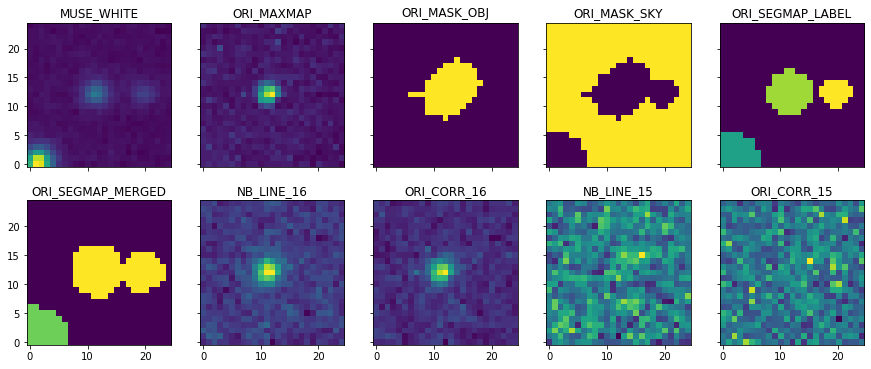

In [58]:
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols,3*nrows), sharex=True, sharey=True)
for ax, (name, im) in zip(axes.flat, src.images.items()):
    im.plot(ax=ax, title=name, show_xlabel=False, show_ylabel=False)
for i in range(nrows*ncols, nimg, -1):
    axes.flat[i - 1].axis('off')

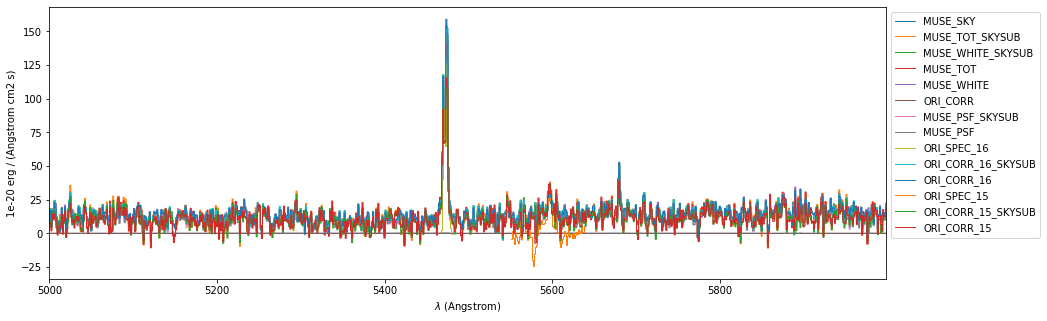

In [59]:
plt.figure(figsize=(15,5))
for name, sp in src.spectra.items():
    sp.plot(label=name)
plt.legend(loc='upper left', bbox_to_anchor=(1,1));